# Playing Pac-Man with Deep Q-Learning

Parts of this notebook has been reproduced from the [Hands-On Machine Learning with Scikit-Learn and TensorFlow](https://www.amazon.co.uk/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1491962291) book.

Additional installation of packages is required to get this working:
- For windows: `pip install --no-index -f https://github.com/Kojoley/atari-py/releases atari_py`

From [this](https://stackoverflow.com/a/46739299/490332) stackoverflow question. 

Testing the environment to ensure everything is working:

In [1]:
from collections import namedtuple
from itertools import count
import random

import gym
from IPython import display
import numpy as np
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T

In [2]:
%matplotlib inline

In [3]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=1)

In [4]:
env = gym.make('MsPacman-v0')
obs = env.reset()
obs.shape

(210, 160, 3)

In [5]:
len(env.step(0))

4

In [6]:
env.action_space

Discrete(9)

We have 9 discrete possible actions to mimic those possible on the joystick:
- left
- right
- up
- down
- centre
- upper left
- upper right
- lower left
- lower right

The observations of the game are 3D numpy arrays. To increase computation speed, the 3D arrays will be converted to greyscale and also reduced in resolution to 88 x 80 with the following function:

In [7]:
# pacman = np.array([210, 164, 74]).mean()
# def preprocess_game_imge(observation: np.array) -> np.array:
#     img = obs[1:176:2, ::2]
#     img = img.mean(axis=2)
#     img[img==pacman] = 0 # improve the constrast of pacman
# #     img = (img // 3 - 128).astype(np.uint8) # normalise from -1 to 1
#     img = (img - 128) / 128 - 1
#     return img.reshape(88, 80, 1)


pacman = 210 + 164 + 74
def preprocess_game_imge(obs):
    img = obs[1:176:2, ::2] # crop and downsize
    img = img.sum(axis=2) # to greyscale
    img[img==pacman] = 0 # Improve contrast
    img = (img // 3 - 128).astype(np.int8) # normalize from -128 to 127
    return img.reshape(88, 80, 1)

In [8]:
preprocess_game_imge(obs).shape

(88, 80, 1)

(-0.5, 79.5, 87.5, -0.5)

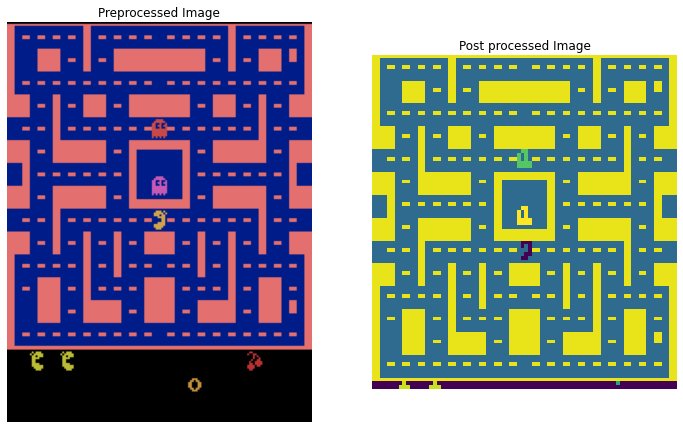

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
ax[0].imshow(obs)
ax[0].set_title('Preprocessed Image')
ax[0].axis('off')
ax[1].imshow(preprocess_game_imge(obs).reshape(88, 80))
# ax[1].imshow(preprocess_game_imge(obs).reshape(88, 80), interpolation='nearest', cmap='gray')
ax[1].set_title('Post processed Image')
ax[1].axis('off')

In [10]:
# Functions for the fancy videos
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), frames=len(frames), repeat=repeat, interval=interval)


In [11]:
frames = []
env = gym.make('MsPacman-v0')
obs = env.reset()
for step in range(500):
    img = env.render(mode='rgb_array')
    frames.append(img)
    # hard-coded policy
    action = random.randrange(9)
    obs, reward, done, info = env.step(action)
    if done:
        break
env.close()

<IPython.core.display.Javascript object>


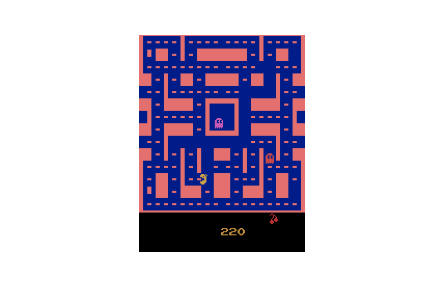

In [12]:
%matplotlib notebook
%matplotlib notebook
plot_animation(frames)

In [13]:
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        # ADD BATCH NORM
        self.conv1 = nn.Conv2d(1, 32, 8, stride=4, padding=2)
#         self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2, padding=1)
#         self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
#         self.bn3 = nn.BatchNorm2d(64)
        self.linear1 = nn.Linear(7040, 512)
        self.linear2 = nn.Linear(512, 9)
        
    def forward(self, input_tensor):
        out = F.relu(self.conv1(input_tensor))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        out = out.view(out.size(0), -1)
        out = F.relu(self.linear1(out))
        return self.linear2(out)

In [14]:
Image2Tensor = T.ToTensor()

## Replay Memory

We’ll be using experience replay memory for training our DQN. It stores the transitions that the agent observes, allowing us to reuse this data later. By sampling from it randomly, the transitions that build up a batch are decorrelated. It has been shown that this greatly stabilizes and improves the DQN training procedure.

The replay memory stores a `Transition` object which in this case is a named tuple. This represents a single transition in our environment. The object requires 4 inputs:
- **state**: The current state (image of the game)
- **action**: Action take on the state
- **next_state**: The next state after the action is taken (image of the game)
- **reward**: Reward for taking the given action

Overall the replay memory acts as a buffer storing $n$ transitions observed most recently. At regular intervals the replay memory is sampled for a batch of memories and used to estimate Q-values.

In [15]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

In [16]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## Action Selection

As the agent plays the game we don't only want it select an action based on Q-values but we also want to to explore the game aswell using a uniformly chosen random action that where epsilon greedy comes in. The `select_action` function below will select an action according to epsilon greedy. Sometimes the model is used for choosing the action and sometimes a random one is chosen. The probability of choosing a random action will start at `EPS_START` and will decay exponentially towards `EPS_END`. The `EPS_DECAY` controls the rate of decay.

In [25]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            state = state.unsqueeze(0).to(device, dtype=torch.float)
            actions = policy_net(state)
            if len(actions.size()) == 1:
                return actions.view(1,9).max(1)[1].view(1,1)
            else:
                return policy_net(state).max(1)[1].view(1,1)
    else:
        n_actions = 9 # number of actions possible in the game
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

In [26]:
steps_done = 0

BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 1.0
EPS_END = 0.1
EPS_DECAY = 4_000_000
TARGET_UPDATE = 10_000 # How frequently to update the target_net in terms of episodes completed
TRAINING_STEP = 4
START_TRAINING = 10_000

policy_net = DQN().to(device)
target_net = DQN().to(device)


learning_rate = 0.0001
momentum = 0.95
optimiser = optim.SGD(policy_net.parameters(), lr=learning_rate, momentum=momentum, nesterov=True)
# optimiser = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(500_000)

episode_durations = []
episode_rewards = []

Text(0, 0.5, 'Probability')

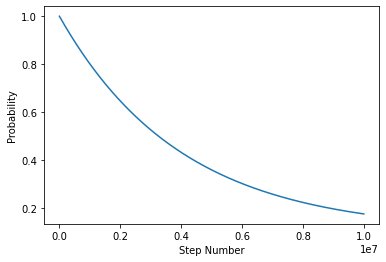

In [27]:
%matplotlib inline
%matplotlib inline
plt.plot(
    [i for i in range(10_000_000)],
    [EPS_END + (EPS_START - EPS_END) * np.exp(-1. * i / EPS_DECAY) for i in range(10_000_000)]
)
plt.xlabel('Step Number')
plt.ylabel('Probability')

The plot above shows how the probability of choosing a random action changes as the agent completes steps. Early on in training there is a high probability of choosing a random action giving the agent more room for exploration. As training progesses this probability descreases and we rely more on the model for choosing the action.

In [28]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
#     non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).to(device, dtype=torch.float)

    state_batch = torch.cat(batch.state).to(device, dtype=torch.float)
    action_batch = torch.cat(batch.action).to(device)
#     action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
#     state_batch = state_batch.view(128,1,88,80) # resize to 4D
    state_batch = state_batch.view(128,1,88,80) # resize to 4D
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
#     next_state_values = torch.zeros(BATCH_SIZE)
    non_final_next_states = non_final_next_states.view(non_final_next_states.size()[0], 1, 88, 80)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values.cpu() * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1).to(device))

    # Optimize the model
    optimiser.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimiser.step()

You may have notcied we created two `DQN`s (`policy_net` and `target_net`). The `policy_net` is used to the play the game. As it plays the game, the states are stored into the `ReplayMemory` instance. So what about the `target_net` how does this learn? In short form, it tries to make its Q-value match that of the `policy_net` from its experience of playing the game. As mentioned earlier, every so often the replay memory is sampled and will try to estimate the Q-values from these memories. The `target_net` is then trained in a typical supervised manner. Once this is done the weights of the `target_net` are copied over to the `policy_net`, which should improve the performance and therefore allowing the agent to last longer in the game.

In [29]:
def plot_durations():
    display.clear_output(wait=True)
    fig, axes = plt.subplots(1, 2, figsize=(15, 8))
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    episode_rewards_t = torch.tensor(episode_rewards, dtype=torch.float)
    axes[0].set_xlabel('Episode')
    axes[0].set_ylabel('Duration')
    axes[0].plot(durations_t.numpy())

    axes[1].set_xlabel('Episode')
    axes[1].set_ylabel('Reward')
    axes[1].plot(episode_rewards_t.numpy())

    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        axes[0].plot(means.numpy())

    if len(episode_rewards_t) >= 100:
        means = episode_rewards_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        axes[1].plot(means.numpy())
    plt.show()

In [30]:
# start_episode = 0
# def continue_training():
#     with open('./models/replay_memory.pkl', 'rb') as in_mem:
#         memory = pickle.load(in_mem)
#     policy_net.load_state_dict(torch.load('./models/agent_4000.pth'))
#     target_net.load_state_dict(torch.load('./models/agent_4000.pth'))
#     return memory, policy_net, target_net
# memory, policy_net, target_net = continue_training()
# start_episode = 4000

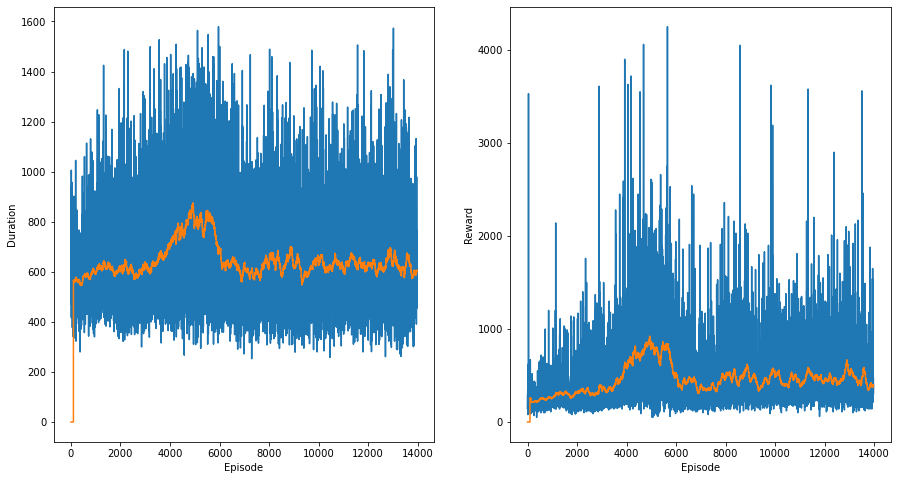

Complete


In [36]:
start_episode = 12_000
num_episodes = 14_000
for i_episode in range(start_episode, num_episodes):

    # Initialize the environment and state
    _ = env.reset()
    
    # Need to skip over the first steps as nothing happens
    for step in range(90):
        action = random.randrange(9)
        obs, reward, done, info = env.step(action)

#     state = Image2Tensor(preprocess_game_imge(obs)).float().to(device, dtype=torch.float)
    state = Image2Tensor(preprocess_game_imge(obs)).float()
    current_state = state
    episode_reward = 0
    for t in count():
        
        # Select and perform an action
        action = select_action(state)
        state, reward, done, _ = env.step(action.item())
#         reward = torch.tensor([reward], device=device)
        reward = torch.tensor([reward])
        episode_reward += reward

        # Observe new state
        last_state = current_state
#         current_state = Image2Tensor(preprocess_game_imge(state)).to(device, dtype=torch.float)
        current_state = Image2Tensor(preprocess_game_imge(state)).float()
        if not done:
#             next_state = current_state.to(device, dtype=torch.float)
            next_state = current_state
        else:
            next_state = None

        # Store the transition in memory
        memory.push(last_state, action, next_state, reward)

        # Move to the next state
        state = next_state

        if steps_done < START_TRAINING:
            if done:
                break
            else:
                continue
            
        # Perform one step of the optimization (on the target network)
        if steps_done % 4 == 0:
            optimize_model()

        # Update the target network, copying all weights and biases in DQN
        if steps_done % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())
    
        if done:
            episode_durations.append(t + 1)
            episode_rewards.append(episode_reward)
            if i_episode % 10 == 0:
                plot_durations()
            break

    if i_episode % 250 == 0:
        torch.save(policy_net.state_dict(), f'./models/agent_{i_episode}.pth')

print('Complete')

In [61]:
len(memory)

500000

In [32]:
i_episode

9999

In [35]:
np.sum(episode_durations)

7746380

In [36]:
import pickle
with open('./models/replay_memory.pkl', 'wb') as out:
    pickle.dump(memory, out)

c:\users\harpal\appdata\local\pypoetry\cache\virtualenvs\theory-62htib5e-py3.7\lib\site-packages\torch\storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)
